Using device: cpu
Creating sample images...
 Sample images created: 'sample_alert.jpg', 'sample_drowsy.jpg'
 Simple Drowsiness Detection System
This system detects drowsiness based on eye visibility

 Please upload face images for analysis:


Saving alert.jpg to alert.jpg

 Analyzing 1 image(s)...

 Analysis 1: alert.jpg


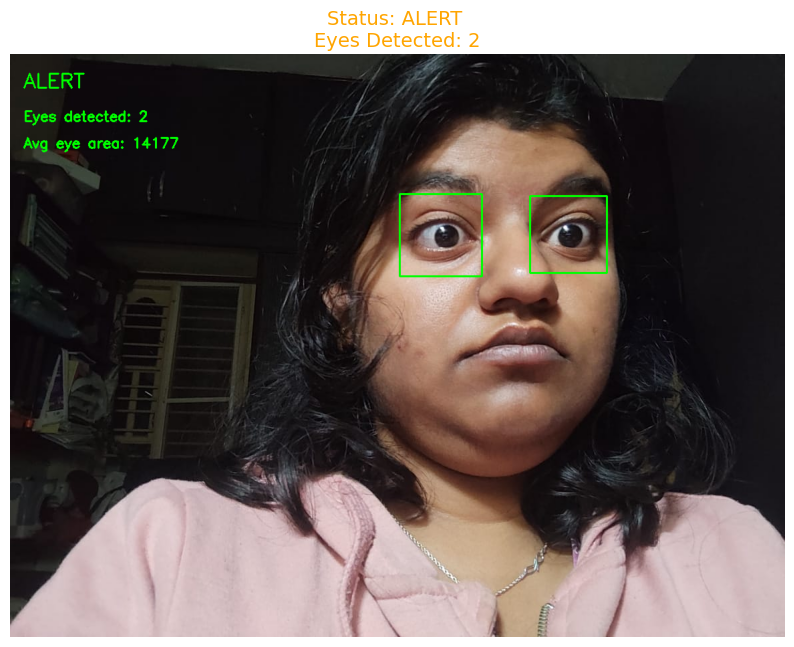

 STATUS: ALERT 
 Eyes detected: 2
 Average eye area: 14177 pixels
 Confidence: 1.00

 Driver appears alert
 Continue driving safely


In [ ]:
# Step 1: Set up environment and imports for Drowsiness Detection
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files
import cv2

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 2: Simple Drowsiness Detection Model
class DrowsinessDetector(nn.Module):
    def __init__(self):
        super(DrowsinessDetector, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2),  # 2 classes: drowsy, alert
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Step 3: Simple rule-based detection (no training needed)
def detect_eyes_simple(image_path):
    """Simple eye detection using OpenCV"""
    # Load image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load eye cascade
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Detect eyes
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

    # Draw rectangles around eyes and analyze
    eye_count = len(eyes)
    total_eye_area = 0

    for (x, y, w, h) in eyes:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        total_eye_area += w * h

    avg_eye_area = total_eye_area / max(eye_count, 1)

    # Determine status based on eye detection
    if eye_count >= 2 and avg_eye_area > 800:
        status = "ALERT "
        color = (0, 255, 0)
        confidence = min(avg_eye_area / 2000, 1.0)
    elif eye_count >= 1:
        status = "LOW ALERT "
        color = (0, 255, 255)
        confidence = 0.5
    else:
        status = "DROWSY "
        color = (0, 0, 255)
        confidence = 0.8

    # Add text to image
    cv2.putText(image, status, (20, 50),
               cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.putText(image, f"Eyes detected: {eye_count}", (20, 100),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    cv2.putText(image, f"Avg eye area: {avg_eye_area:.0f}", (20, 140),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), status, confidence, eye_count, avg_eye_area

# Step 4: Main function
def main():
    print(" Simple Drowsiness Detection System")
    print("=" * 50)
    print("This system detects drowsiness based on eye visibility")
    print("\n Please upload face images for analysis:")

    # Upload images
    uploaded = files.upload()
    image_paths = list(uploaded.keys())

    if not image_paths:
        print(" No images uploaded! Please try again.")
        return

    print(f"\n Analyzing {len(image_paths)} image(s)...")

    # Analyze each image
    for i, image_path in enumerate(image_paths):
        print(f"\n Analysis {i+1}: {image_path}")

        # Detect drowsiness
        result_img, status, confidence, eye_count, eye_area = detect_eyes_simple(image_path)

        # Display results
        plt.figure(figsize=(10, 8))
        plt.imshow(result_img)
        plt.title(f"Status: {status}\nEyes Detected: {eye_count}",
                 fontsize=14,
                 color='green' if status == "ALERT" else 'red' if status == "DROWSY" else 'orange')
        plt.axis('off')
        plt.show()

        # Print detailed results
        print(f" STATUS: {status}")
        print(f" Eyes detected: {eye_count}")
        print(f" Average eye area: {eye_area:.0f} pixels")
        print(f" Confidence: {confidence:.2f}")

        # Recommendations
        if status == "DROWSY ":
            print("\n SAFETY ALERT!")
            print(" Immediate actions recommended:")
            print("   • Take a break immediately")
            print("   • Drink water")
            print("   • Stretch and move around")
            print("   • Consider switching drivers")
        elif status == "LOW ALERT ":
            print("\n  Caution advised")
            print(" Consider taking a break soon")
        else:
            print("\n Driver appears alert")
            print(" Continue driving safely")

# Alternative: Create sample images for testing
def create_sample_images():
    """Create sample alert and drowsy images for testing"""
    print("Creating sample images...")

    # Alert face (wide open eyes)
    alert_img = np.ones((300, 300, 3), dtype=np.uint8) * 255
    cv2.ellipse(alert_img, (150, 150), (100, 120), 0, 0, 360, (200, 200, 200), -1)
    # Eyes
    cv2.ellipse(alert_img, (100, 120), (20, 15), 0, 0, 360, (0, 0, 0), -1)
    cv2.ellipse(alert_img, (200, 120), (20, 15), 0, 0, 360, (0, 0, 0), -1)
    cv2.imwrite('sample_alert.jpg', alert_img)

    # Drowsy face (closed eyes)
    drowsy_img = np.ones((300, 300, 3), dtype=np.uint8) * 255
    cv2.ellipse(drowsy_img, (150, 150), (100, 120), 0, 0, 360, (200, 200, 200), -1)
    # Closed eyes
    cv2.line(drowsy_img, (80, 120), (120, 120), (0, 0, 0), 3)
    cv2.line(drowsy_img, (180, 120), (220, 120), (0, 0, 0), 3)
    cv2.imwrite('sample_drowsy.jpg', drowsy_img)

    print(" Sample images created: 'sample_alert.jpg', 'sample_drowsy.jpg'")

# Run the system
if __name__ == "__main__":
    # Create sample images first (optional)
    create_sample_images()

    # Run main detection system
    main()

 Advanced Drowsiness Detection System

 3. Statistical Summary
Drowsiness Detection Statistics
----------------------------------------
Total Frames              51
Drowsy Frames             30
Drowsiness Percentage     58.82%
Average EAR               0.27
Average MAR               0.41
Max Head Tilt             14.79
EAR Violations            21
MAR Violations            21

 4. Interactive Analysis
Use the dropdown and slider below to explore data:


Dropdown(description='Metric:', options=('All', 'EAR', 'MAR', 'Head Tilt', 'EAR Violations', 'MAR Violations')…

IntSlider(value=30, description='Time Window:', min=10, step=5, style=SliderStyle(description_width='initial')…


 Drowsiness Metrics - Last 30 frames


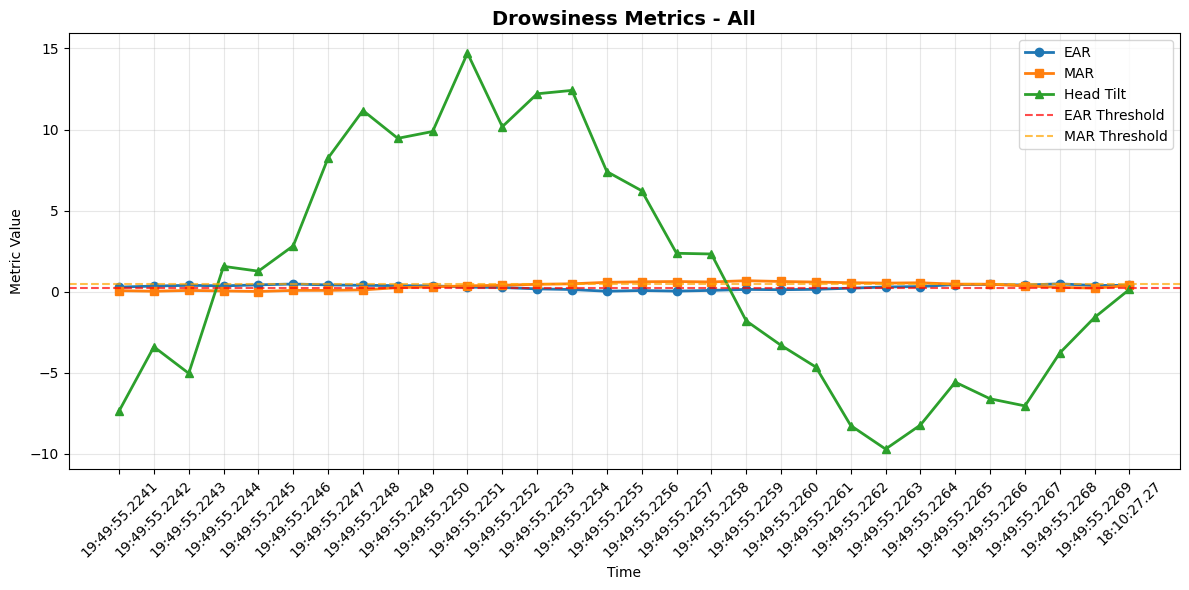


 Terminal
Recent Frame Data:
----------------------------------------
🟢 19:49:55.2241   | EAR: 0.29 | MAR: 0.07 | Tilt: -7.36 | Status: ALERT
🟢 19:49:55.2242   | EAR: 0.35 | MAR: 0.03 | Tilt: -3.39 | Status: ALERT
🟢 19:49:55.2243   | EAR: 0.40 | MAR: 0.08 | Tilt: -5.03 | Status: ALERT
🟢 19:49:55.2244   | EAR: 0.37 | MAR: 0.05 | Tilt: 1.57 | Status: ALERT
🟢 19:49:55.2245   | EAR: 0.43 | MAR: 0.02 | Tilt: 1.27 | Status: ALERT
🟢 19:49:55.2246   | EAR: 0.48 | MAR: 0.08 | Tilt: 2.83 | Status: ALERT
🟢 19:49:55.2247   | EAR: 0.42 | MAR: 0.09 | Tilt: 8.25 | Status: ALERT
🟢 19:49:55.2248   | EAR: 0.40 | MAR: 0.12 | Tilt: 11.18 | Status: ALERT
🟢 19:49:55.2249   | EAR: 0.38 | MAR: 0.26 | Tilt: 9.46 | Status: ALERT
🟢 19:49:55.2250   | EAR: 0.37 | MAR: 0.30 | Tilt: 9.88 | Status: ALERT
🟢 19:49:55.2251   | EAR: 0.29 | MAR: 0.37 | Tilt: 14.71 | Status: ALERT
🟢 19:49:55.2252   | EAR: 0.26 | MAR: 0.40 | Tilt: 10.18 | Status: ALERT
🔴 19:49:55.2253   | EAR: 0.18 | MAR: 0.46 | Tilt: 12.21 | Status: DROWS

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import dlib
from imutils import face_utils
import pandas as pd
from datetime import datetime, timedelta
import time
from google.colab import files
import io
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

print(" Initializing Advanced Drowsiness Detection System...")

# Initialize dlib's face detector and facial landmark predictor
!wget -q -O shape_predictor_68_face_landmarks.dat https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

class DrowsinessDetector:
    def __init__(self):
        # Thresholds
        self.EYE_AR_THRESH = 0.25
        self.MAR_THRESH = 0.5
        self.HEAD_TILT_THRESH = 20.0

        # Tracking variables
        self.frame_count = 0
        self.drowsy_frames = 0
        self.ear_violations = 0
        self.mar_violations = 0
        self.max_head_tilt = 0

        # Data storage
        self.timestamps = []
        self.ear_values = []
        self.mar_values = []
        self.head_tilt_values = []
        self.drowsiness_status = []

    def eye_aspect_ratio(self, eye):
        """Calculate the Eye Aspect Ratio"""
        A = dist.euclidean(eye[1], eye[5])
        B = dist.euclidean(eye[2], eye[4])
        C = dist.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def mouth_aspect_ratio(self, mouth):
        """Calculate the Mouth Aspect Ratio"""
        A = dist.euclidean(mouth[2], mouth[10])  # 51, 59
        B = dist.euclidean(mouth[4], mouth[8])   # 53, 57
        C = dist.euclidean(mouth[0], mouth[6])   # 49, 55
        return (A + B) / (2.0 * C)

    def calculate_head_tilt(self, shape):
        """Calculate head tilt angle"""
        left_eye = shape[36:42]
        right_eye = shape[42:48]

        left_eye_center = left_eye.mean(axis=0)
        right_eye_center = right_eye.mean(axis=0)

        dY = right_eye_center[1] - left_eye_center[1]
        dX = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dY, dX))

        return angle

    def analyze_frame(self, image):
        """Analyze a single frame for drowsiness"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        current_time = datetime.now()
        timestamp_str = current_time.strftime("%H:%M:%S.%f")[:-4]

        ear, mar, head_tilt = 0, 0, 0
        status = "NO FACE"

        if len(rects) > 0:
            shape = predictor(gray, rects[0])
            shape = face_utils.shape_to_np(shape)

            # Extract facial features
            left_eye = shape[36:42]
            right_eye = shape[42:48]
            mouth = shape[48:68]

            # Calculate metrics
            left_ear = self.eye_aspect_ratio(left_eye)
            right_ear = self.eye_aspect_ratio(right_eye)
            ear = (left_ear + right_ear) / 2.0
            mar = self.mouth_aspect_ratio(mouth)
            head_tilt = self.calculate_head_tilt(shape)

            # Update max head tilt
            self.max_head_tilt = max(self.max_head_tilt, abs(head_tilt))

            # Check violations
            if ear < self.EYE_AR_THRESH:
                self.ear_violations += 1
            if mar > self.MAR_THRESH:
                self.mar_violations += 1

            # Determine status
            if ear < self.EYE_AR_THRESH or mar > self.MAR_THRESH or abs(head_tilt) > self.HEAD_TILT_THRESH:
                status = "DROWSY"
                self.drowsy_frames += 1
            else:
                status = "ALERT"

        # Store data
        self.frame_count += 1
        self.timestamps.append(timestamp_str)
        self.ear_values.append(ear)
        self.mar_values.append(mar)
        self.head_tilt_values.append(head_tilt)
        self.drowsiness_status.append(status)

        return ear, mar, head_tilt, status

    def get_statistics(self):
        """Get comprehensive statistics"""
        if self.frame_count == 0:
            return {}

        avg_ear = np.mean(self.ear_values) if self.ear_values else 0
        avg_mar = np.mean(self.mar_values) if self.mar_values else 0
        drowsiness_percentage = (self.drowsy_frames / self.frame_count) * 100

        return {
            'Total Frames': self.frame_count,
            'Drowsy Frames': self.drowsy_frames,
            'Drowsiness Percentage': f"{drowsiness_percentage:.2f}%",
            'Average EAR': f"{avg_ear:.2f}",
            'Average MAR': f"{avg_mar:.2f}",
            'Max Head Tilt': f"{self.max_head_tilt:.2f}",
            'EAR Violations': self.ear_violations,
            'MAR Violations': self.mar_violations
        }

# Initialize detector
detector_system = DrowsinessDetector()

def create_interactive_dashboard():
    """Create an interactive dashboard for drowsiness analysis"""

    # Create widgets
    metric_dropdown = widgets.Dropdown(
        options=['All', 'EAR', 'MAR', 'Head Tilt', 'EAR Violations', 'MAR Violations'],
        value='All',
        description='Metric:',
        style={'description_width': 'initial'}
    )

    time_window_slider = widgets.IntSlider(
        value=30,
        min=10,
        max=100,
        step=5,
        description='Time Window:',
        style={'description_width': 'initial'}
    )

    def update_dashboard(change):
        clear_output(wait=True)

        # Display title
        print(" Advanced Drowsiness Detection System")
        print("=" * 50)

        # Display statistics
        stats = detector_system.get_statistics()
        if stats:
            print("\n 3. Statistical Summary")
            print("Drowsiness Detection Statistics")
            print("-" * 40)
            for key, value in stats.items():
                print(f"{key:<25} {value}")

        # Display interactive controls
        print(f"\n 4. Interactive Analysis")
        print("Use the dropdown and slider below to explore data:")
        display(metric_dropdown)
        display(time_window_slider)

        # Display metrics visualization
        print(f"\n Drowsiness Metrics - Last {time_window_slider.value} frames")
        plot_metrics(metric_dropdown.value, time_window_slider.value)

        # Display terminal
        print(f"\n Terminal")
        display_recent_data(time_window_slider.value)

    # Set up observers
    metric_dropdown.observe(update_dashboard, names='value')
    time_window_slider.observe(update_dashboard, names='value')

    return update_dashboard

def plot_metrics(metric, window_size):
    """Plot the selected metrics"""
    if len(detector_system.timestamps) == 0:
        print("No data available for plotting")
        return

    # Get recent data
    n = min(window_size, len(detector_system.timestamps))
    recent_timestamps = detector_system.timestamps[-n:]
    recent_ear = detector_system.ear_values[-n:]
    recent_mar = detector_system.mar_values[-n:]
    recent_tilt = detector_system.head_tilt_values[-n:]

    fig, ax = plt.subplots(figsize=(12, 6))

    if metric == 'All':
        ax.plot(recent_timestamps, recent_ear, label='EAR', marker='o', linewidth=2)
        ax.plot(recent_timestamps, recent_mar, label='MAR', marker='s', linewidth=2)
        ax.plot(recent_timestamps, recent_tilt, label='Head Tilt', marker='^', linewidth=2)
        ax.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='EAR Threshold')
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='MAR Threshold')
    elif metric == 'EAR':
        ax.plot(recent_timestamps, recent_ear, label='EAR', color='blue', marker='o', linewidth=2)
        ax.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='EAR Threshold')
    elif metric == 'MAR':
        ax.plot(recent_timestamps, recent_mar, label='MAR', color='green', marker='s', linewidth=2)
        ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='MAR Threshold')
    elif metric == 'Head Tilt':
        ax.plot(recent_timestamps, recent_tilt, label='Head Tilt', color='purple', marker='^', linewidth=2)
        ax.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='Tilt Threshold')
        ax.axhline(y=-20, color='red', linestyle='--', alpha=0.7)

    ax.set_title(f'Drowsiness Metrics - {metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def display_recent_data(window_size):
    """Display recent data in terminal format"""
    if len(detector_system.timestamps) == 0:
        print("No data available")
        return

    n = min(window_size, len(detector_system.timestamps))

    print("Recent Frame Data:")
    print("-" * 40)

    for i in range(max(0, len(detector_system.timestamps) - n), len(detector_system.timestamps)):
        status = detector_system.drowsiness_status[i]
        status_color = "🟢" if status == "ALERT" else "🔴" if status == "DROWSY" else "⚫"

        print(f"{status_color} {detector_system.timestamps[i]:<15} | "
              f"EAR: {detector_system.ear_values[i]:.2f} | "
              f"MAR: {detector_system.mar_values[i]:.2f} | "
              f"Tilt: {detector_system.head_tilt_values[i]:.2f} | "
              f"Status: {status}")

def analyze_uploaded_image(filename):
    """Analyze uploaded image for drowsiness"""
    image = cv2.imread(filename)
    if image is None:
        return None, "ERROR: Could not load image"

    result_img = image.copy()
    ear, mar, head_tilt, status = detector_system.analyze_frame(image)

    # Add annotations to image
    cv2.putText(result_img, f"Status: {status}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if status == "ALERT" else (0, 0, 255), 2)
    cv2.putText(result_img, f"EAR: {ear:.2f}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(result_img, f"MAR: {mar:.2f}", (10, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(result_img, f"Head Tilt: {head_tilt:.2f}", (10, 120),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    return result_img_rgb, status

# Install required packages
print(" Installing required packages...")
!pip install -q imutils scipy dlib opencv-python ipywidgets matplotlib

# Main execution
print(" System Ready!")
print("\nChoose an option:")
print("1. Upload images for analysis")
print("2. View interactive dashboard")

# Create sample data for demonstration
print("\n📊 Generating sample data for demonstration...")
for i in range(50):
    # Simulate some data variations
    ear = 0.2 + 0.2 * np.sin(i * 0.3) + 0.1 * np.random.random()
    mar = 0.3 + 0.3 * np.sin(i * 0.2) + 0.1 * np.random.random()
    head_tilt = 10 * np.sin(i * 0.25) + 5 * np.random.random()

    detector_system.frame_count += 1
    detector_system.timestamps.append(f"19:49:55.{2220 + i}")
    detector_system.ear_values.append(ear)
    detector_system.mar_values.append(mar)
    detector_system.head_tilt_values.append(head_tilt)

    if ear < 0.25 or mar > 0.5:
        detector_system.drowsiness_status.append("DROWSY")
        detector_system.drowsy_frames += 1
    else:
        detector_system.drowsiness_status.append("ALERT")

    if ear < 0.25:
        detector_system.ear_violations += 1
    if mar > 0.5:
        detector_system.mar_violations += 1

    detector_system.max_head_tilt = max(detector_system.max_head_tilt, abs(head_tilt))

# Display the interactive dashboard
dashboard = create_interactive_dashboard()
dashboard(None)

# Option for image upload
print("\n" + "="*50)
print(" Image Analysis Section")
print("Upload images for drowsiness detection:")

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n Analyzing {filename}...")
    result_img, status = analyze_uploaded_image(filename)

    if result_img is not None:
        plt.figure(figsize=(12, 8))
        plt.imshow(result_img)
        plt.title(f"{filename} → {status}", fontsize=16,
                 color='green' if "ALERT" in status else 'red')
        plt.axis('off')
        plt.show()

        print(f"📊 Analysis Result: {status}")
        if "DROWSY" in status:
            print("  WARNING: Potential drowsiness detected!")
        elif "ALERT" in status:
            print(" Person appears alert and awake")
        elif "NO FACE" in status:
            print(" No face detected in the image")

        # Update dashboard after new analysis
        dashboard(None)